# Data Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path

PROJECT_ROOT = Path("/content/drive/MyDrive/Bharde_429_Final")
PROJECT_ROOT.mkdir(parents=True, exist_ok=True)

ZIP_PATH = PROJECT_ROOT / "asl-alphabet.zip"

print("Project root:", PROJECT_ROOT)
print("Zip exists:", ZIP_PATH.exists())

Mounted at /content/drive
Project root: /content/drive/MyDrive/Bharde_429_Final
Zip exists: True


In [2]:
import shutil, os, subprocess

LOCAL_BASE  = Path("/content/asl_alphabet_unzipped")
LOCAL_TRAIN = LOCAL_BASE / "asl_alphabet_train"
LOCAL_TEST  = LOCAL_BASE / "asl_alphabet_test"

LOCAL_BASE.mkdir(parents=True, exist_ok=True)

if LOCAL_TRAIN.exists() and any(LOCAL_TRAIN.iterdir()):
    print("Using existing local unzipped data at:", LOCAL_TRAIN)
else:
    assert ZIP_PATH.exists(), "asl-alphabet.zip not found in PROJECT_ROOT."
    print("Unzipping from Drive zip -> /content ...")
    !unzip -q -o "{ZIP_PATH}" -d "{LOCAL_BASE}"

    # wrapper folder: /content/asl_alphabet_unzipped/asl_alphabet/*
    wrapper = LOCAL_BASE / "asl_alphabet"
    if wrapper.exists():
        inner_train = wrapper / "asl_alphabet_train"
        inner_test  = wrapper / "asl_alphabet_test"
        if inner_train.exists():
            LOCAL_TRAIN.mkdir(exist_ok=True)
            for item in inner_train.iterdir():
                shutil.move(str(item), str(LOCAL_TRAIN))
        if inner_test.exists():
            LOCAL_TEST.mkdir(exist_ok=True)
            for item in inner_test.iterdir():
                shutil.move(str(item), str(LOCAL_TEST))
        shutil.rmtree(wrapper, ignore_errors=True)

    # double-nest: .../asl_alphabet_train/asl_alphabet_train/*
    inner_train2 = LOCAL_TRAIN / "asl_alphabet_train"
    if inner_train2.exists():
        for item in inner_train2.iterdir():
            shutil.move(str(item), str(LOCAL_TRAIN))
        shutil.rmtree(inner_train2, ignore_errors=True)

    inner_test2 = LOCAL_TEST / "asl_alphabet_test"
    if inner_test2.exists():
        for item in inner_test2.iterdir():
            shutil.move(str(item), str(LOCAL_TEST))
        shutil.rmtree(inner_test2, ignore_errors=True)

print("Train root:", LOCAL_TRAIN)
print("Test root :", LOCAL_TEST)
!ls -l "{LOCAL_TRAIN}" | head

Unzipping from Drive zip -> /content ...
Train root: /content/asl_alphabet_unzipped/asl_alphabet_train
Test root : /content/asl_alphabet_unzipped/asl_alphabet_test
total 2300
drwxr-xr-x 2 root root  73728 Nov 16 19:21 A
drwxr-xr-x 2 root root  73728 Nov 16 19:21 B
drwxr-xr-x 2 root root  73728 Nov 16 19:21 C
drwxr-xr-x 2 root root  73728 Nov 16 19:21 D
drwxr-xr-x 2 root root  81920 Nov 16 19:22 del
drwxr-xr-x 2 root root  77824 Nov 16 19:21 E
drwxr-xr-x 2 root root  73728 Nov 16 19:22 F
drwxr-xr-x 2 root root  73728 Nov 16 19:22 G
drwxr-xr-x 2 root root  77824 Nov 16 19:22 H


In [3]:
from pathlib import Path
import pandas as pd

ACCEPT = {".jpg", ".jpeg", ".png"}

rows = []
for cdir in sorted([d for d in LOCAL_TRAIN.iterdir() if d.is_dir()]):
    label = cdir.name
    count = sum(1 for p in cdir.rglob("*") if p.is_file() and p.suffix.lower() in ACCEPT)
    rows.append((label, count))

counts = pd.DataFrame(rows, columns=["class", "count"]).sort_values("class")
print("Train classes found:", len(counts))
print("Train total images :", counts["count"].sum())
display(counts.head())

test_files = [p for p in LOCAL_TEST.iterdir() if p.is_file() and p.suffix.lower() in ACCEPT]
print("Kaggle test images:", len(test_files))

Train classes found: 29
Train total images : 87000


,class,count
0,A,3000
1,B,3000
2,C,3000
3,D,3000
4,E,3000


Kaggle test images: 28


# Model Training

In [4]:
import json, random, numpy as np
import pandas as pd
from PIL import Image

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import f1_score, confusion_matrix
import contextlib

ART     = PROJECT_ROOT / "artifacts"
CKPT    = PROJECT_ROOT / "checkpoints"; CKPT.mkdir(exist_ok=True)
RESULTS = PROJECT_ROOT / "results";     RESULTS.mkdir(exist_ok=True)

SEED = 429
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

USE_CUDA = torch.cuda.is_available()
DEVICE   = torch.device("cuda" if USE_CUDA else "cpu")
amp_ctx  = torch.autocast(device_type="cuda", dtype=torch.float16) if USE_CUDA else contextlib.nullcontext()
if USE_CUDA:
    torch.backends.cudnn.benchmark = True
print("Device:", DEVICE)

with open(ART / "class_to_idx.json") as f:
    class_to_idx = json.load(f)

classes = [c for c,_ in sorted(class_to_idx.items(), key=lambda kv: kv[1])]
NUM_CLASSES = len(classes)
print("NUM_CLASSES:", NUM_CLASSES, "| first classes:", classes[:5])

df_train = pd.read_csv(ART / "train_manifest.csv")
df_val   = pd.read_csv(ART / "val_manifest.csv")

print("Train rows:", len(df_train), "| Val rows:", len(df_val))

Device: cuda
NUM_CLASSES: 27 | first classes: ['A', 'B', 'C', 'D', 'E']
Train rows: 64800 | Val rows: 16200


In [5]:
IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

class ImageCSV(Dataset):
    def __init__(self, df, transform=None):
        self.paths = df["path"].tolist()
        if "y" in df.columns:
            self.targets = df["y"].astype(int).tolist()
        else:
            self.targets = df["label"].map(class_to_idx).astype(int).tolist()
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.targets[idx]

train_ds = ImageCSV(df_train, tfm)
val_ds   = ImageCSV(df_val,   tfm)

BATCH_SIZE  = 64
NUM_WORKERS = 4

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, persistent_workers=True, prefetch_factor=2
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, persistent_workers=True, prefetch_factor=2
)

print("Train batches:", len(train_loader), "| Val batches:", len(val_loader))

Train batches: 1013 | Val batches: 254


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
# --- T-C: progressive unfreezing: layer3 + layer4 + head ---

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
in_feats = model.fc.in_features
model.fc = nn.Linear(in_feats, NUM_CLASSES)

# start from best T-B weights
tb_ckpt_path = CKPT / "best_TB.pt"
state_dict   = torch.load(tb_ckpt_path, map_location="cpu")
model.load_state_dict(state_dict)
print("Loaded T-B weights from:", tb_ckpt_path)

# freeze everything first
for p in model.parameters():
    p.requires_grad = False

# unfreeze layer3, layer4, head
for p in model.layer3.parameters():
    p.requires_grad = True
for p in model.layer4.parameters():
    p.requires_grad = True
for p in model.fc.parameters():
    p.requires_grad = True

def set_frozen_bn_eval(m):
    if isinstance(m, nn.BatchNorm2d):
        if all(not p.requires_grad for p in m.parameters()):
            m.eval()

model.apply(set_frozen_bn_eval)

model = model.to(DEVICE).to(memory_format=torch.channels_last)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    [p for p in model.parameters() if p.requires_grad],
    lr=1e-4
)

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"T-C trainable params: {trainable:,} / {total:,}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 88.9MB/s]


Loaded T-B weights from: /content/drive/MyDrive/Bharde_429_Final/checkpoints/best_TB.pt
T-C trainable params: 10,507,291 / 11,190,363


In [7]:
def _batch_correct(logits, y):
    preds = logits.argmax(1)
    return preds, (preds == y).sum().item()

@torch.no_grad()
def evaluate(model, loader, return_preds=False):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    all_pred, all_true = [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE, memory_format=torch.channels_last)
        yb = torch.as_tensor(yb, device=DEVICE)
        with amp_ctx:
            logits = model(xb)
            loss = criterion(logits, yb)
        loss_sum += loss.item() * xb.size(0)
        preds, corr = _batch_correct(logits, yb)
        all_pred.extend(preds.cpu().tolist())
        all_true.extend(yb.cpu().tolist())
        correct += corr; total += xb.size(0)
    acc = correct / total
    f1  = f1_score(all_true, all_pred, average="macro")
    if return_preds:
        return loss_sum/total, acc, f1, (all_pred, all_true)
    return loss_sum/total, acc, f1

In [8]:
from copy import deepcopy

EPOCHS = 5
history_TC = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[], "val_f1":[]}

best_f1    = -1.0
best_state = None
patience, bad = 1, 0   # stop after 2 non-improving epochs

for epoch in range(1, EPOCHS + 1):
    model.train()
    tr_tot, tr_corr, tr_loss_sum = 0, 0, 0.0

    for xb, yb in train_loader:
        xb = xb.to(DEVICE, memory_format=torch.channels_last)
        yb = torch.as_tensor(yb, device=DEVICE)

        optimizer.zero_grad(set_to_none=True)
        with amp_ctx:
            logits = model(xb)
            loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        tr_loss_sum += loss.item() * xb.size(0)
        preds, corr = _batch_correct(logits, yb)
        tr_corr += corr; tr_tot += xb.size(0)

    tr_loss = tr_loss_sum / tr_tot
    tr_acc  = tr_corr / tr_tot

    va_loss, va_acc, va_f1 = evaluate(model, val_loader)

    history_TC["train_loss"].append(tr_loss)
    history_TC["train_acc"].append(tr_acc)
    history_TC["val_loss"].append(va_loss)
    history_TC["val_acc"].append(va_acc)
    history_TC["val_f1"].append(va_f1)

    tag = ""
    if va_f1 > best_f1:
        best_f1    = va_f1
        best_state = deepcopy(model.state_dict())
        bad = 0
        tag = "<= BEST"
    else:
        bad += 1

    print(
        f"Epoch {epoch:02d} | "
        f"train {tr_loss:.4f}/{tr_acc:.3f} | "
        f"val {va_loss:.4f}/{va_acc:.3f} F1 {va_f1:.4f} {tag}"
    )

    if bad > patience:
        print("Early stopping (macro-F1 plateau).")
        break

best_TC_path = CKPT / "best_TC.pt"
torch.save(best_state, best_TC_path)
print("Saved best T-C checkpoint:", best_TC_path, "| Best val macro-F1:", f"{best_f1:.4f}")

Epoch 01 | train 0.0036/0.999 | val 0.0009/1.000 F1 0.9998 <= BEST
Epoch 02 | train 0.0001/1.000 | val 0.0000/1.000 F1 1.0000 <= BEST
Epoch 03 | train 0.0001/1.000 | val 0.0000/1.000 F1 1.0000 
Epoch 04 | train 0.0000/1.000 | val 0.0000/1.000 F1 1.0000 
Early stopping (macro-F1 plateau).
Saved best T-C checkpoint: /content/drive/MyDrive/Bharde_429_Final/checkpoints/best_TC.pt | Best val macro-F1: 1.0000


In [9]:
import numpy as np

pd.DataFrame(history_TC).to_csv(RESULTS / "TC_history.csv", index=False)
print("Saved:", RESULTS / "TC_history.csv")

Saved: /content/drive/MyDrive/Bharde_429_Final/results/TC_history.csv


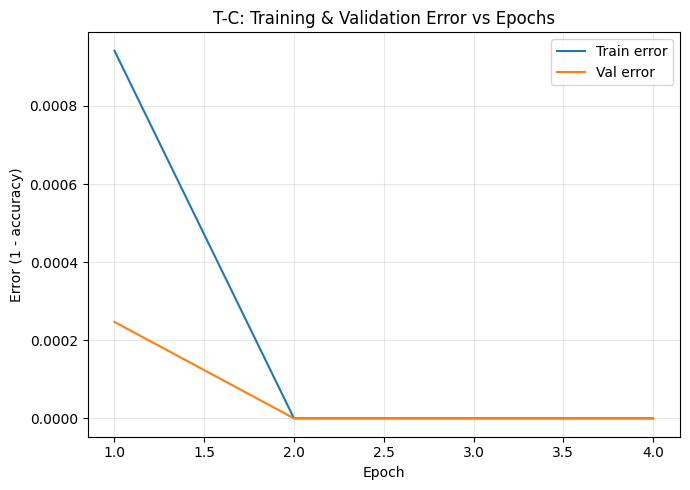

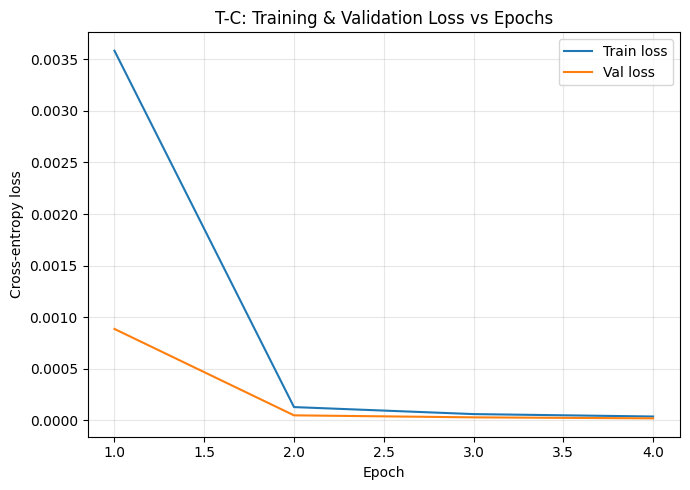

In [10]:
import matplotlib.pyplot as plt

hist_TC = pd.read_csv(RESULTS / "TC_history.csv")
epochs  = range(1, len(hist_TC) + 1)

# error curves (1 - accuracy)
plt.figure(figsize=(7,5))
plt.plot(epochs, 1 - hist_TC["train_acc"], label="Train error")
plt.plot(epochs, 1 - hist_TC["val_acc"],   label="Val error")
plt.xlabel("Epoch"); plt.ylabel("Error (1 - accuracy)")
plt.title("T-C: Training & Validation Error vs Epochs")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig(RESULTS / "TC_error_curves.png", dpi=200)
plt.show()

# loss curves
plt.figure(figsize=(7,5))
plt.plot(epochs, hist_TC["train_loss"], label="Train loss")
plt.plot(epochs, hist_TC["val_loss"],   label="Val loss")
plt.xlabel("Epoch"); plt.ylabel("Cross-entropy loss")
plt.title("T-C: Training & Validation Loss vs Epochs")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig(RESULTS / "TC_loss_curves.png", dpi=200)
plt.show()

# Model Testing

In [13]:
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image

def evaluate_folder(folder, mode="flat", save_tag="results"):
    """
    Evaluate the model on all images in a folder.
    Expects filenames like A_test_1.jpg, B_test_4.jpg, etc.
    """
    folder = Path(folder)
    paths = sorted([p for p in folder.iterdir() if p.suffix.lower() in {".jpg",".jpeg",".png"}])

    true_labels = []
    pred_labels = []

    model.eval()
    with torch.no_grad():
        for p in paths:
            # true label from filename
            true_lbl = p.name.split("_")[0]   # Extract "A" from "A_test_3.jpg"
            true_labels.append(true_lbl)

            # load + preprocess
            img = Image.open(p).convert("RGB")
            x = tfm(img).unsqueeze(0).to(DEVICE)

            # predict
            logits = model(x)
            pred_idx = torch.argmax(logits, dim=1).item()
            pred_lbl = classes[pred_idx]
            pred_labels.append(pred_lbl)

    # accuracy + macro-F1
    acc = (np.array(true_labels) == np.array(pred_labels)).mean()

    from sklearn.metrics import f1_score, confusion_matrix
    f1 = f1_score(true_labels, pred_labels, average="macro")
    cm = confusion_matrix(true_labels, pred_labels, labels=classes)

    # save predictions
    df = pd.DataFrame({
        "file": [p.name for p in paths],
        "true_label": true_labels,
        "pred_label": pred_labels
    })
    df.to_csv(RESULTS / f"{save_tag}_predictions.csv", index=False)
    np.save(RESULTS / f"{save_tag}_cm.npy", cm)

    print(f"[{save_tag}] files: {len(paths)} | acc: {acc:.4f} | macro-F1: {f1:.4f}")
    print(f"Saved: {save_tag}_predictions.csv and {save_tag}_cm.npy")

    return acc, f1, cm

In [16]:
# rebuild test model with best T-C weights
model_test = models.resnet18(weights=None)
model_test.fc = nn.Linear(model_test.fc.in_features, NUM_CLASSES)
model_test.load_state_dict(torch.load(best_TC_path, map_location=DEVICE))
model_test = model_test.to(DEVICE).eval()

idx_to_class = {v:k for k,v in class_to_idx.items()}

KAGGLE_TEST_DIR = LOCAL_TEST
MY_TEST_DIR     = Path("/content/drive/MyDrive/Bharde_429_Final/new_asl_alphabet_test")

acc_kagg_TC, f1_kagg_TC, cm_kagg_TC = evaluate_folder(
    KAGGLE_TEST_DIR, mode="flat", save_tag="TC_kaggle28"
)

acc_cust_TC, f1_cust_TC, cm_cust_TC = evaluate_folder(
    MY_TEST_DIR, mode="flat", save_tag="TC_custom"
)

print("\nT-C Kaggle 28  -> acc =", f"{acc_kagg_TC:.4f}", ", macro-F1 =", f"{f1_kagg_TC:.4f}")
print("T-C Custom 20 -> acc =", f"{acc_cust_TC:.4f}", ", macro-F1 =", f"{f1_cust_TC:.4f}")

[TC_kaggle28] files: 28 | acc: 0.9643 | macro-F1: 0.9524
Saved: TC_kaggle28_predictions.csv and TC_kaggle28_cm.npy
[TC_custom] files: 20 | acc: 0.0500 | macro-F1: 0.0444
Saved: TC_custom_predictions.csv and TC_custom_cm.npy

T-C Kaggle 28  -> acc = 0.9643 , macro-F1 = 0.9524
T-C Custom 20 -> acc = 0.0500 , macro-F1 = 0.0444
